In [1]:
#Import Deliverables
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
#Print first row to view field names and data
measurement_first_row = session.query(Measurement).first()
measurement_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x269222def48>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [11]:
#Print first row to view field names and data
station_first_row = session.query(Station).first()
station_first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x269222ab988>,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

In [12]:
#Confirm table names
inspector = inspect(engine) 
inspector.get_table_names()

['measurement', 'station']

In [13]:
#Use inspector to view table names and data type
columns = inspector.get_columns('measurement')

for column in columns:
    print(column["name"], column["type"], "*PK*" if column['primary_key'] else '')

id INTEGER *PK*
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [14]:
#Use inspector to view table names and data type
data_list = inspector.get_columns('station')
for data in data_list:
    print(data["name"], data["type"], "*PK*" if data['primary_key'] else '')

id INTEGER *PK*
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Climate Analysis

In [15]:
#Pull the last month in the Measurement data
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
# Calculate the date 1 year ago from the last data point in the database
one_year_diff=dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("1 year ago from the last data point: ", one_year_diff)

1 year ago from the last data point:  2016-08-23


In [17]:
# Perform a query to retrieve the data and precipitation scores
precipitation= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_diff).all()


In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(precipitation, columns = ['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)

precipitation_df

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [19]:
# Sort the dataframe by date
date_ordered=precipitation_df.sort_index(ascending=True)

date_ordered.dropna()

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


<Figure size 2520x2880 with 0 Axes>

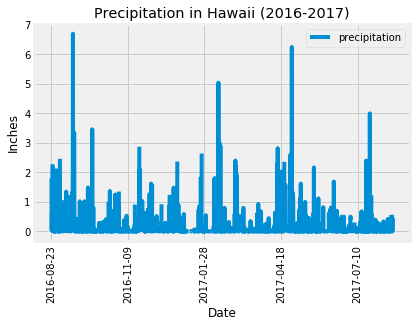

<Figure size 432x288 with 0 Axes>

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(35,40))
date_ordered.plot()

plt.xticks(rotation='vertical')
# Add the descriptive title, x labels and y labels
plt.title("Precipitation in Hawaii (2016-2017)")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()
plt.savefig("Precipitation_Hawaii.png")


In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_ordered.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [22]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(Measurement.station).distinct().count()
print(f'Total number of stations in dataset: {station_count}')

Total number of stations in dataset: 9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count= (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
 # Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_temperature=session.query(func.min(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
highest_temperature=session.query(func.max(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temperature=session.query(func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').all()
avg_temperature= '{0:.3}'.format(avg_temperature[0][0])
print(f'The lowest temperature is: {lowest_temperature} degrees Fahrenheit')
print(f'The highest temperature is: {highest_temperature} degrees Fahrenheit')
print(f'The average temperature is: {avg_temperature} degrees Fahrenheit')

The lowest temperature is: [(54.0,)] degrees Fahrenheit
The highest temperature is: [(85.0,)] degrees Fahrenheit
The average temperature is: 71.7 degrees Fahrenheit


In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_by_station= session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>=one_year_diff).filter(Measurement.station=='USC00519281').all()
#save as a data frame
temp_by_station_df = pd.DataFrame(temp_by_station, columns = ['date', 'temperature'])
temperature_table = temp_by_station_df.set_index('date')

temperature_table

,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


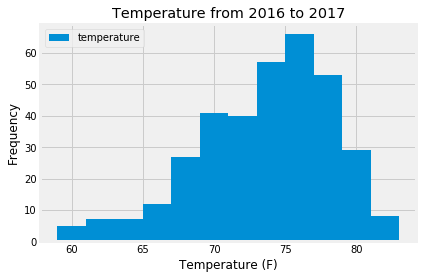

In [26]:
#Plot histogram
fig, ax = plt.subplots()
temperature_table.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Frequency')
ax.set_title("Temperature from 2016 to 2017")


plt.savefig("Temp_Histogram.png")

plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calculating_temp = calc_temps('2017-01-01','2017-01-14')

calculating_temp_df = pd.DataFrame(calculating_temp, columns=["tmin","tavg","tmax"])
calculating_temp_df 

,tmin,tavg,tmax
0,60.0,68.47619,81.0


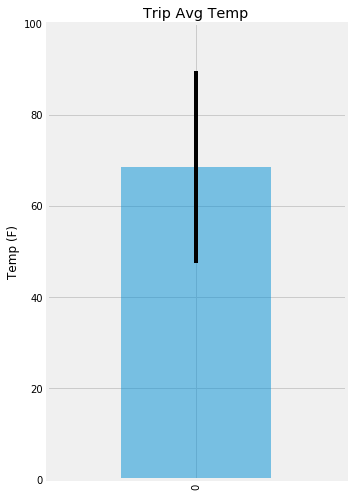

<Figure size 432x288 with 0 Axes>

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calculating_temp_df.plot.bar(y='tavg', yerr=(calculating_temp_df['tmax'] - calculating_temp_df['tmin']), title='Trip Avg Temp', alpha=0.5, figsize=(5,7))
plt.xticks = np.arange(len(calculating_temp_df))
plt.ylabel("Temp (F)")
plt.ylim(0, 100)
plt.tight_layout()
plt.gca().legend_.remove()
plt.show()
plt.savefig("Trip_Avg_Temp.png")

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_weather=session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
                filter(Measurement.station==Station.station).\
                filter(Measurement.date>='2017-01-01').\
                filter(Measurement.date<='2017-01-14').\
                group_by(Measurement.station).\
                order_by(Measurement.prcp.desc()).all()

trip_weather_df = pd.DataFrame(trip_weather, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])
trip_weather_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.29
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.03
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.03
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.00
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,NaN
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate = '2017-01-01'
enddate = '2017-01-14'

# Use the start and end date to create a range of dates
start_date = dt.datetime.strptime(startdate, '%Y-%m-%d')
end_date = dt.datetime.strptime(enddate, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

dates = []
normals =[]
while (start_date <= end_date):
    dates.append(dt.datetime.strftime(start_date,'%Y-%m-%d'))
    dates_strings = dt.datetime.strftime(start_date,'%m-%d')
    normals.append(list(np.ravel(daily_normals(dates_strings))))
    start_date = start_date + dt.timedelta(days = 1)

normals

[[62.0, 69.15384615384616, 77.0],
 [60.0, 69.39622641509433, 77.0],
 [62.0, 68.9090909090909, 77.0],
 [58.0, 70.0, 76.0],
 [56.0, 67.96428571428571, 76.0],
 [61.0, 68.96491228070175, 76.0],
 [57.0, 68.54385964912281, 76.0],
 [57.0, 67.16071428571429, 75.0],
 [58.0, 67.9298245614035, 78.0],
 [62.0, 69.74137931034483, 77.0],
 [57.0, 67.3103448275862, 78.0],
 [57.0, 67.4074074074074, 81.0],
 [57.0, 67.25454545454545, 77.0],
 [58.0, 69.52631578947368, 77.0]]

In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['TMIN','TAVG','TMAX'])
normals_df['Date'] = dates
normals_df=normals_df.set_index('Date')

normals_df

,TMIN,TAVG,TMAX
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


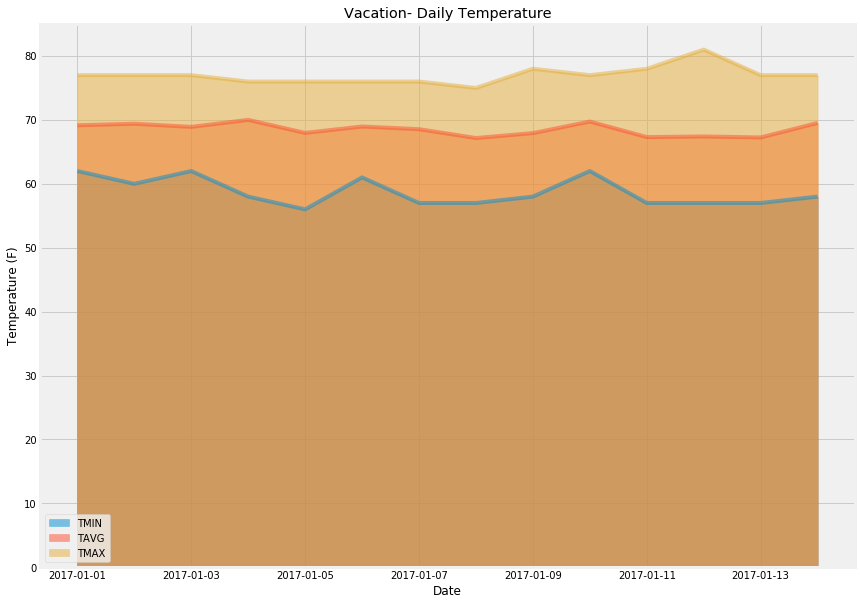

In [34]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (13, 10))
normals_df.plot.area(ax = ax, stacked=False)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (F)')
ax.set_title('Vacation- Daily Temperature')

#save figure
plt.savefig('normals_df.png')